In [19]:
# Import packages

import rasterio
import rasterio.mask
from rasterio.plot import reshape_as_image 
from rasterio.plot import reshape_as_raster
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import branca
import folium
import shapely
import json

In [6]:
# Reading incidents data
df = pd.read_csv("../Advanced Data Science Data/Incidents_clean.csv")

display(df)
# duration = endtime_new - starttime_new [min]


,type,starttime_new,endtime_new,vild_primair_wegnummer,primaire_locatie_lengtegraad,primaire_locatie_breedtegraad,duration
0,vehicle_obstruction,2019-08-28 12:11:32,2019-12-11 11:32:28,A1,4.974663,52.346931,151160.933333
1,vehicle_obstruction,2019-08-28 12:11:32,2019-12-11 11:32:28,A9,4.716725,52.514820,151160.933333
2,vehicle_obstruction,2019-08-28 12:11:32,2019-12-11 11:32:28,A9,4.738364,52.609730,151160.933333
3,vehicle_obstruction,2019-08-28 12:11:32,2019-12-11 11:32:28,A35,6.824692,52.204929,151160.933333
4,vehicle_obstruction,2019-08-28 12:11:32,2019-12-11 11:32:28,A4,4.346407,52.041920,151160.933333
...,...,...,...,...,...,...,...
88846,vehicle_obstruction,2019-12-31 23:43:49,2019-12-31 23:43:49,NaN,4.475721,51.893230,0.000000
88847,accident,2019-12-31 23:46:10,2019-12-31 23:46:10,N246,4.701406,52.443363,0.000000
88848,vehicle_obstruction,2019-12-31 23:47:01,2019-12-31 23:47:01,N31,5.922628,53.165226,0.000000
88849,vehicle_obstruction,2019-12-31 23:55:23,2019-12-31 23:55:23,A4,4.313686,51.442677,0.000000


In [8]:
# Importing CORUP shape file
COROP = gpd.read_file("../Advanced Data Science Data/COROP/B14_COROP_gebieden/B14_COROP_gebiedenPolygon.shp")

In [11]:
COROP["geometry"].head(5)

0    POLYGON ((110246.009 523141.422, 110489.039 52...
1    POLYGON ((192680.259 417166.229, 192896.767 41...
2    POLYGON ((190084.310 369500.089, 191500.139 36...
3    POLYGON ((185595.689 341998.739, 185819.884 34...
4    MULTIPOLYGON (((187236.837 503916.995, 187073....
Name: geometry, dtype: geometry

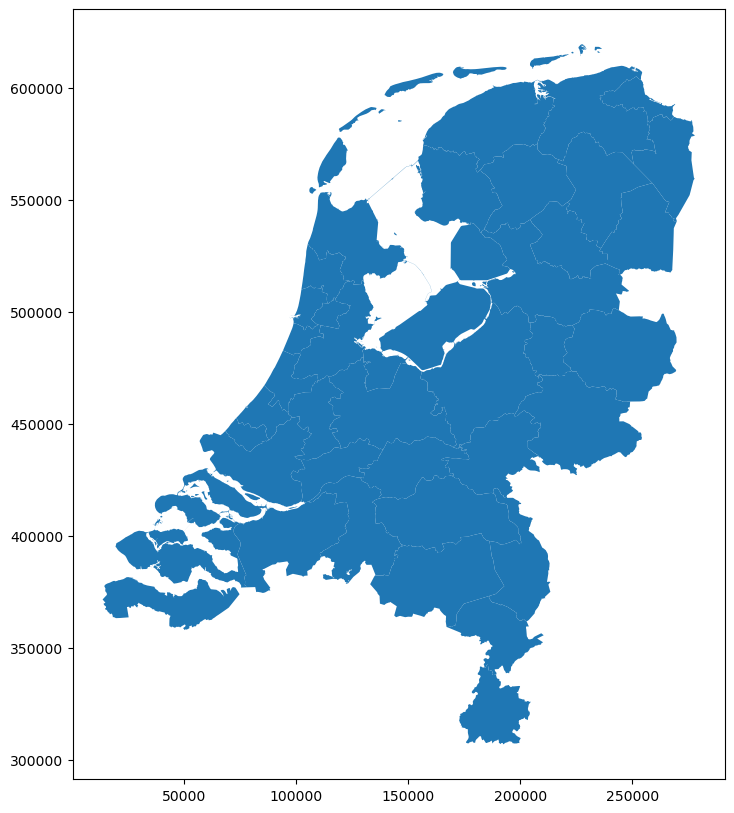

In [10]:
# Check if loaded correctly
fig, ax = plt.subplots(figsize = (10,10))
COROP.plot(ax=ax)
plt.show()

In [20]:
g = [i for i in COROP.geometry]
poly_mapped = shapely.geometry.mapping(g[0])
poly_coordinates = poly_mapped['coordinates'][0]

poly_ = [{'lat': coords[1],'lon': coords[0]} for coords in poly_coordinates]

print(json.dumps(poly_))

[{"lat": 523141.422, "lon": 110246.009}, {"lat": 522867.035, "lon": 110489.039}, {"lat": 523021.448, "lon": 110705.633}, {"lat": 523483.853, "lon": 112049.13}, {"lat": 523600.868, "lon": 113103.272}, {"lat": 523624.052, "lon": 113175.106}, {"lat": 523664.956, "lon": 113254.029}, {"lat": 523964.045, "lon": 113326.895}, {"lat": 524769.529, "lon": 113318.373}, {"lat": 526020.74, "lon": 113494.076}, {"lat": 526855.168, "lon": 113783.536}, {"lat": 527212.668, "lon": 113876.092}, {"lat": 527269.375, "lon": 113921.989}, {"lat": 526899.114, "lon": 114424.656}, {"lat": 526723.866, "lon": 114443.938}, {"lat": 526288.388, "lon": 114341.609}, {"lat": 526126.032, "lon": 114422.29}, {"lat": 526046.794, "lon": 114926.276}, {"lat": 526073.015, "lon": 115155.507}, {"lat": 525965.921, "lon": 115160.266}, {"lat": 525360.388, "lon": 115659.355}, {"lat": 525497.887, "lon": 116533.176}, {"lat": 525560.714, "lon": 116772.402}, {"lat": 525708.114, "lon": 117095.814}, {"lat": 525946.705, "lon": 118283.307}, {"

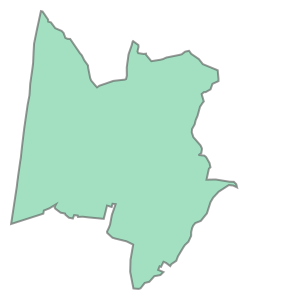

In [21]:
# think of a way to filter incidents by coordinates in the COROP area.
# 